In [1]:
import warnings
# 모든 경고를 무시
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import seaborn
from sklearn.metrics import f1_score
import missingno as msno
import gdown
from scipy.stats import chi2_contingency


gdown.download('https://drive.google.com/uc?id=16ApwcdLGYhU3EjphBtDsE9rbIfFMRHTM','Telco.csv',quiet=False)

# 한글 글꼴 경로 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 유니코드 음수 기호 비활성화
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv("Telco.csv")
for idx, col in enumerate(df.columns):
    print(f"Index: {idx}, Column Name: {col}")

Downloading...
From: https://drive.google.com/uc?id=16ApwcdLGYhU3EjphBtDsE9rbIfFMRHTM
To: C:\Users\sang\Desktop\last\Telco.csv
100%|███████████████████████████████████████████████████████████████████████████████| 978k/978k [00:00<00:00, 4.62MB/s]

Index: 0, Column Name: customerID
Index: 1, Column Name: gender
Index: 2, Column Name: SeniorCitizen
Index: 3, Column Name: Partner
Index: 4, Column Name: Dependents
Index: 5, Column Name: tenure
Index: 6, Column Name: PhoneService
Index: 7, Column Name: MultipleLines
Index: 8, Column Name: InternetService
Index: 9, Column Name: OnlineSecurity
Index: 10, Column Name: OnlineBackup
Index: 11, Column Name: DeviceProtection
Index: 12, Column Name: TechSupport
Index: 13, Column Name: StreamingTV
Index: 14, Column Name: StreamingMovies
Index: 15, Column Name: Contract
Index: 16, Column Name: PaperlessBilling
Index: 17, Column Name: PaymentMethod
Index: 18, Column Name: MonthlyCharges
Index: 19, Column Name: TotalCharges
Index: 20, Column Name: Churn


In [3]:
# 결측치 확인
for col in df.select_dtypes(include=['object', 'int', 'float']).columns:
    has_blank_or_nan = df[col].isna().sum() + (df[col] == ' ').sum()
    print(f"{col}: {has_blank_or_nan} 개의 공백 또는 NaN")

customerID: 0 개의 공백 또는 NaN
gender: 0 개의 공백 또는 NaN
SeniorCitizen: 0 개의 공백 또는 NaN
Partner: 0 개의 공백 또는 NaN
Dependents: 0 개의 공백 또는 NaN
tenure: 0 개의 공백 또는 NaN
PhoneService: 0 개의 공백 또는 NaN
MultipleLines: 0 개의 공백 또는 NaN
InternetService: 0 개의 공백 또는 NaN
OnlineSecurity: 0 개의 공백 또는 NaN
OnlineBackup: 0 개의 공백 또는 NaN
DeviceProtection: 0 개의 공백 또는 NaN
TechSupport: 0 개의 공백 또는 NaN
StreamingTV: 0 개의 공백 또는 NaN
StreamingMovies: 0 개의 공백 또는 NaN
Contract: 0 개의 공백 또는 NaN
PaperlessBilling: 0 개의 공백 또는 NaN
PaymentMethod: 0 개의 공백 또는 NaN
MonthlyCharges: 0 개의 공백 또는 NaN
TotalCharges: 11 개의 공백 또는 NaN
Churn: 0 개의 공백 또는 NaN


<Axes: >

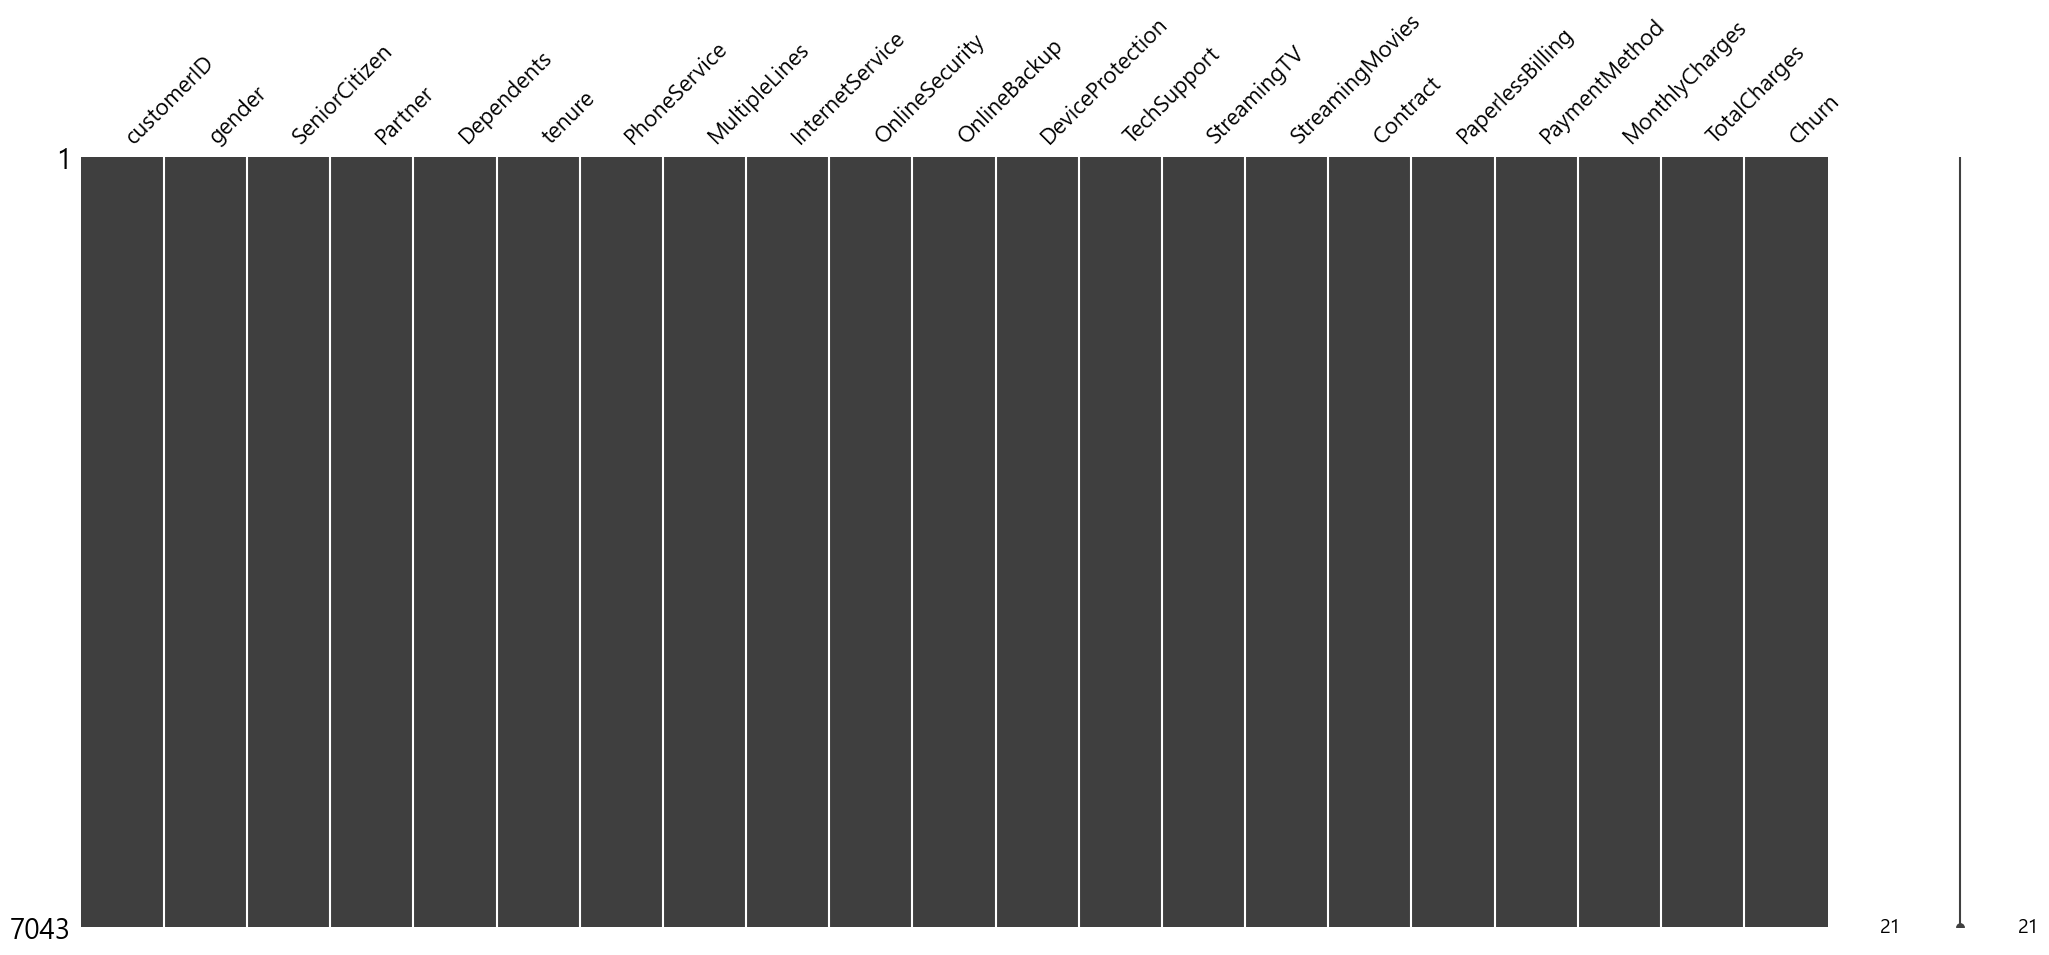

In [4]:
msno.matrix(df)

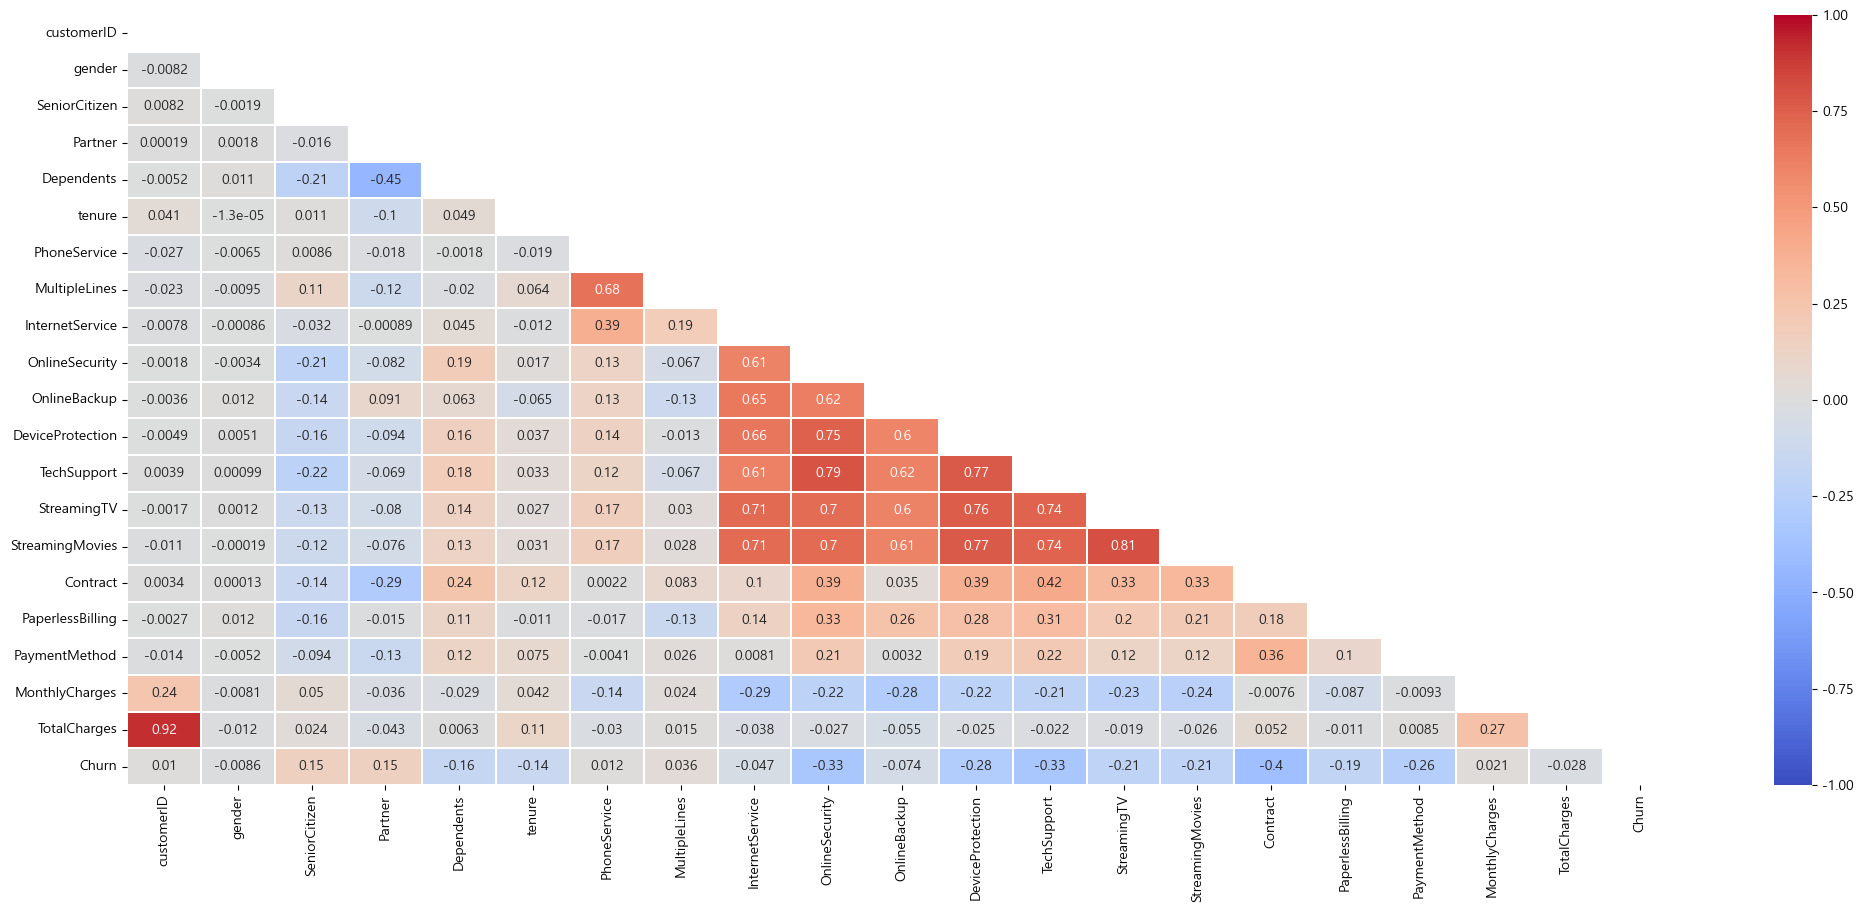

In [5]:
# 모든 변수끼리의 상관관계 확인(Heatmap)
plt.figure(figsize=(25, 10))
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = seaborn.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

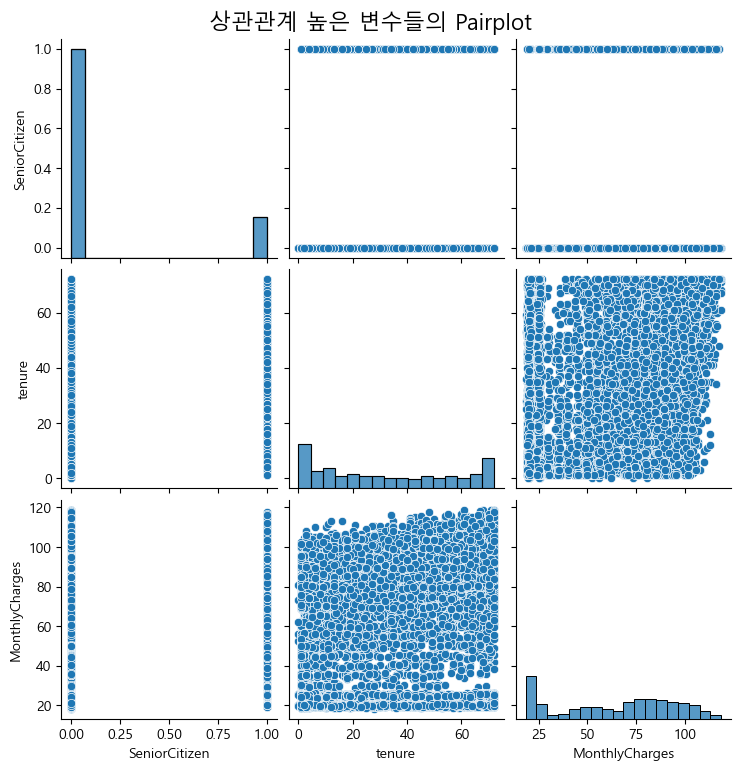

In [6]:
# 상관계수 필터링 (절댓값 0.75 이상)
filtered_corr = corr[abs(corr) >= 0.75]

high_corr_vars = filtered_corr.columns[(filtered_corr != 1).any(axis=0)]

filtered_df = df[high_corr_vars]

# Pairplot 그리기
plt.rcParams['font.family'] = 'Malgun Gothic'
seaborn.pairplot(filtered_df)
plt.suptitle("상관관계 높은 변수들의 Pairplot", y=1.02, fontsize=16)
plt.show()

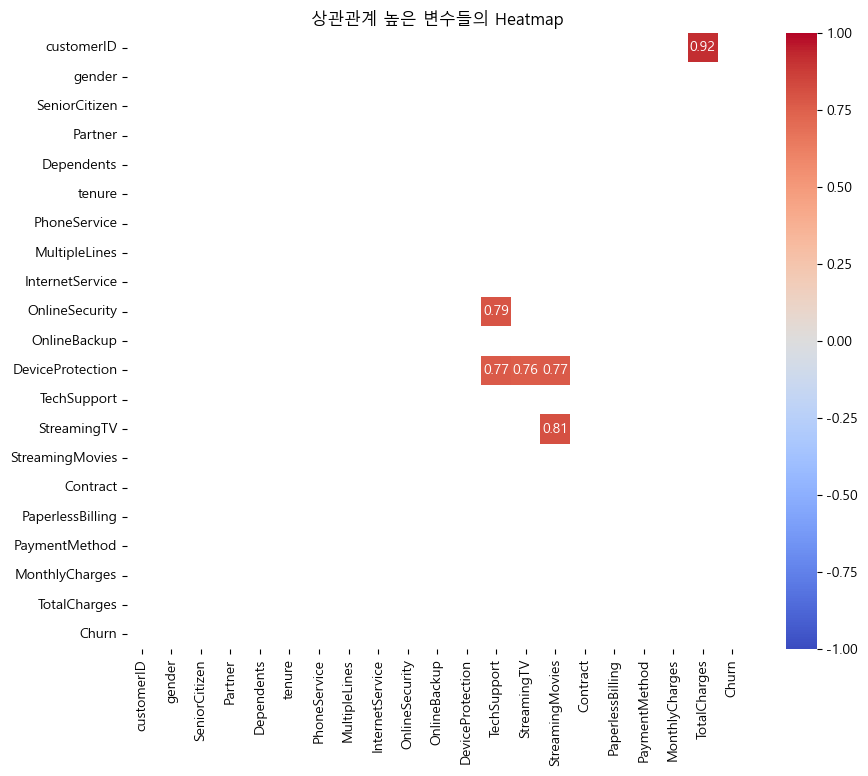

                  TechSupport  StreamingTV  StreamingMovies  TotalCharges
customerID                NaN          NaN              NaN      0.916799
OnlineSecurity       0.791225          NaN              NaN           NaN
DeviceProtection     0.767970     0.763279         0.766821           NaN
StreamingTV               NaN          NaN         0.809608           NaN


In [7]:
# 상관계수 필터링 (절댓값 0.75 이상, 대각선 제외)
filtered_corr = corr.where(np.triu(abs(corr) >= 0.75, k=1))

# Heatmap
plt.figure(figsize=(10, 8))
seaborn.heatmap(filtered_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, xticklabels=filtered_corr.columns, yticklabels=filtered_corr.columns)
plt.title("상관관계 높은 변수들의 Heatmap")
plt.show()
# Null 값이 아닌 값들만 필터링하여 새로운 데이터프레임 생성
non_null_filtered_corr = filtered_corr.dropna(how="all", axis=0).dropna(how="all", axis=1)

# 필터링된 데이터프레임 출력
print(non_null_filtered_corr)

         Variable 1     Variable 2  Chi2 Statistic        P-value  \
0        customerID         gender    7.043000e+03   4.943977e-01   
1        customerID  SeniorCitizen    7.043000e+03   4.943977e-01   
2        customerID        Partner    7.043000e+03   4.943977e-01   
3        customerID     Dependents    7.043000e+03   4.943977e-01   
4        customerID         tenure    5.070960e+05   4.712380e-01   
..              ...            ...             ...            ...   
205   PaymentMethod   TotalCharges    1.985158e+04   9.357833e-02   
206   PaymentMethod          Churn    6.481423e+02  3.682355e-140   
207  MonthlyCharges   TotalCharges    1.078443e+07   0.000000e+00   
208  MonthlyCharges          Churn    2.123609e+03   1.885273e-18   
209    TotalCharges          Churn    6.514048e+03   5.532462e-01   

     Degrees of Freedom Independent  
0                  7042         Yes  
1                  7042         Yes  
2                  7042         Yes  
3                  

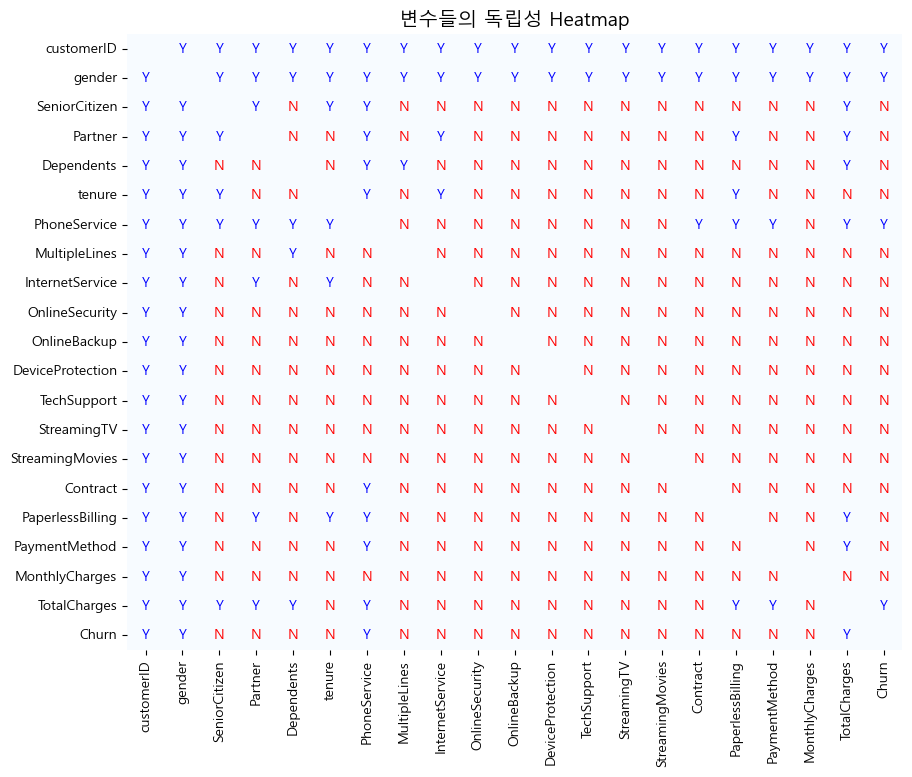

In [8]:
#  카이제곱을통한 변수들간의 독립성 검정(p-value = 0.05)
results = []
columns = df.columns

for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        if i < j:  # 중복 계산 방지
            contingency_table = pd.crosstab(df[col1], df[col2])
            chi2, p, dof, _ = chi2_contingency(contingency_table)
            results.append({
                'Variable 1': col1, 
                'Variable 2': col2,
                'Chi2 Statistic': chi2,
                'P-value': p,
                'Degrees of Freedom': dof,
                'Independent': 'Yes' if p > 0.05 else 'No'
            })

chi2_results = pd.DataFrame(results)

# 독립 여부 히트맵 생성
independence_matrix = np.zeros((len(columns), len(columns)), dtype=str)

for result in results:
    var1_idx = columns.get_loc(result['Variable 1'])
    var2_idx = columns.get_loc(result['Variable 2'])
    independence_matrix[var1_idx, var2_idx] = result['Independent']
    independence_matrix[var2_idx, var1_idx] = result['Independent']

print(chi2_results)

# 결과를 채우기
for result in results:
    var1_idx = columns.get_loc(result['Variable 1'])
    var2_idx = columns.get_loc(result['Variable 2'])
    independence_matrix[var1_idx, var2_idx] = result['Independent']
    independence_matrix[var2_idx, var1_idx] = result['Independent']  # 대칭

# 히트맵 그리기
plt.figure(figsize=(10, 8))
seaborn.heatmap((independence_matrix == 'Yes').astype(int), annot=False, xticklabels=columns, yticklabels=columns, cmap="Blues", cbar=False)

# 텍스트 수동 추가
for i in range(len(columns)):
    for j in range(len(columns)):
        value = independence_matrix[i, j]
        if value:
            text_color = "blue" if value == "Y" else "red"
            plt.text(j + 0.5, i + 0.5, value,ha="center", va="center", color=text_color, fontsize=10)

plt.title("변수들의 독립성 Heatmap", fontsize=14)
plt.show()

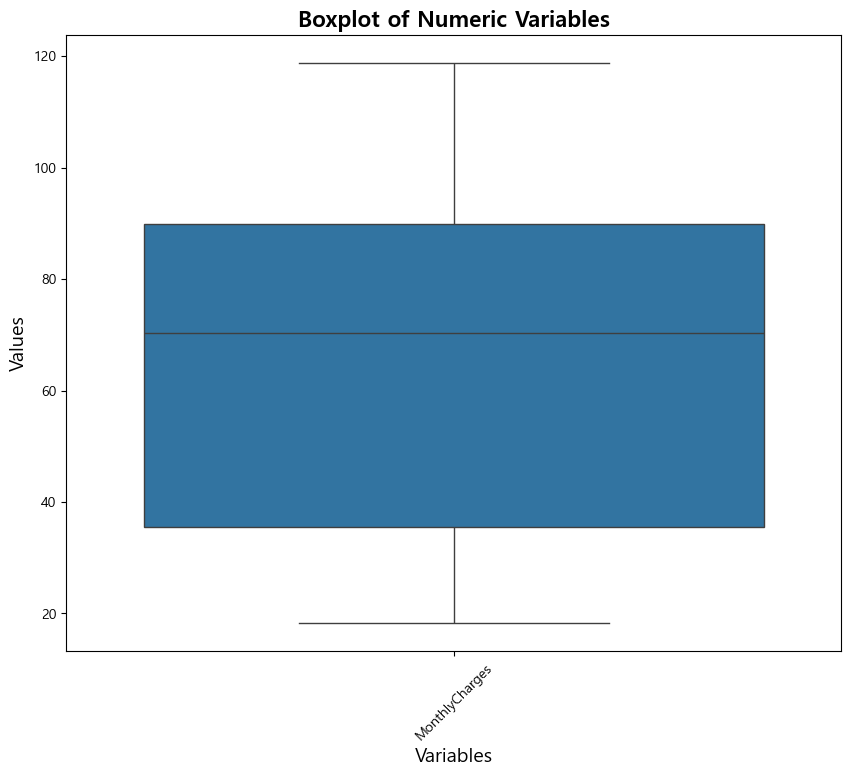

In [9]:
# float형식의 변수들 Boxplot

numeric_df = df.select_dtypes(include='float')

plt.figure(figsize=(10, 8))
seaborn.boxplot(data=numeric_df)

plt.xlabel("Variables", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.title("Boxplot of Numeric Variables", fontsize=16, weight='bold')
plt.xticks(rotation=45)
plt.show()

Lower Bound:
SeniorCitizen      0.000
tenure           -60.000
MonthlyCharges   -46.025
dtype: float64
Upper Bound:
SeniorCitizen       0.000
tenure            124.000
MonthlyCharges    171.375
dtype: float64
Removed 1142 outliers.


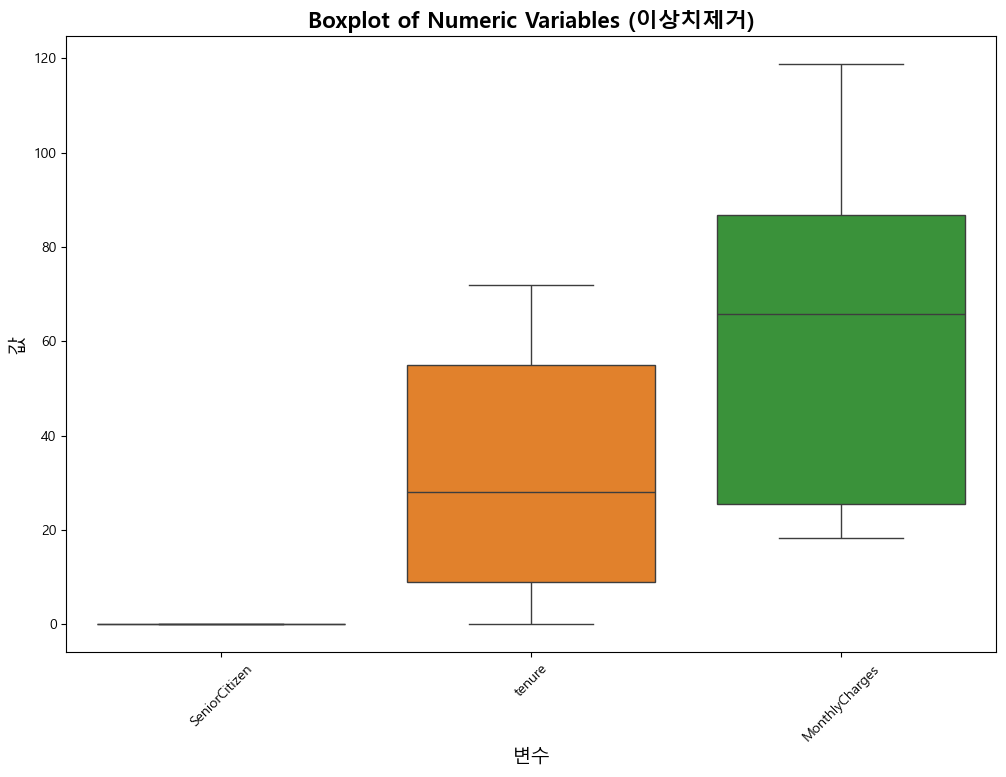

In [10]:
# float형식의 변수들 이상치 제거 후 Boxplot

numeric_df = df.select_dtypes(include='number')

## IQR을 이용하여 이상치 제거 함수 정의
def remove_outliers(df):
    numeric_df = df.select_dtypes(include=[np.number])  
    Q1 = numeric_df.quantile(0.25)
    Q3 = numeric_df.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f"Lower Bound:\n{lower_bound}")
    print(f"Upper Bound:\n{upper_bound}")
    
    df_out = df[~((numeric_df < lower_bound) | (numeric_df > upper_bound)).any(axis=1)]
    print(f"Removed {len(df) - len(df_out)} outliers.")
    return df_out

numeric_df_no_outliers = remove_outliers(numeric_df)

## 이상치 제거 후 박스플롯 그리기
plt.figure(figsize=(12, 8))
seaborn.boxplot(data=numeric_df_no_outliers)
plt.xlabel("변수", fontsize=14)
plt.ylabel("값", fontsize=14)
plt.title("Boxplot of Numeric Variables (이상치제거)", fontsize=16, weight='bold')

plt.xticks(rotation=45)
plt.show()

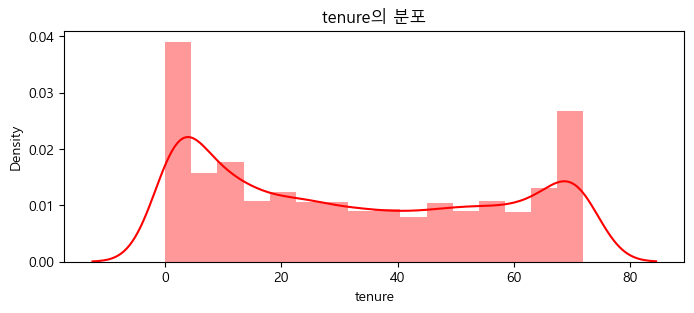

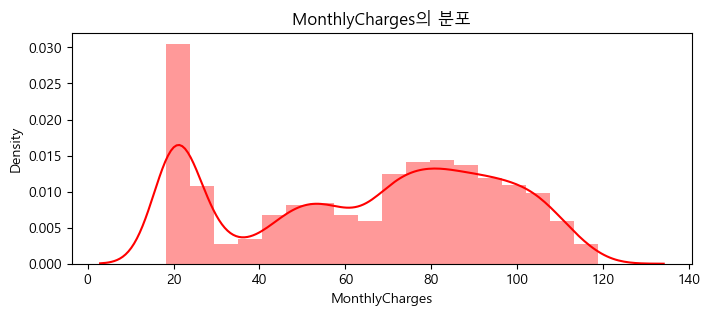

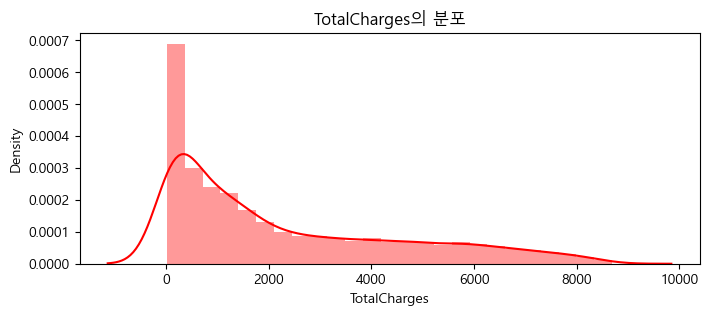

In [11]:
# 수치형 변수들의 분포 확인

## TotalCharges 변수는 object타입이지만 float형식으로 봐야하므로 변경함.
df.replace({'TotalCharges': {' ': np.nan}}, inplace=True)
df['TotalCharges'] = df['TotalCharges'].astype(float)

def distplot(feature, frame, color='r'):
    plt.figure(figsize=(8,3))
    plt.title("{}의 분포".format(feature))
    ax = seaborn.distplot(frame[feature], color= color)
    
num_cols = ["tenure", 'MonthlyCharges', 'TotalCharges']
for feat in num_cols: distplot(feat, df)

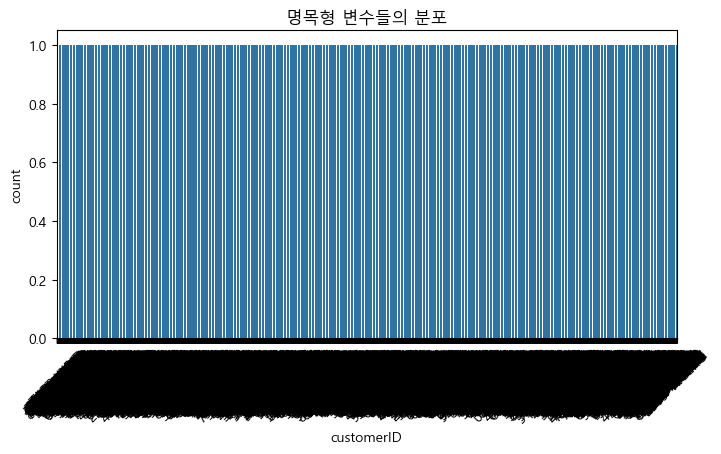

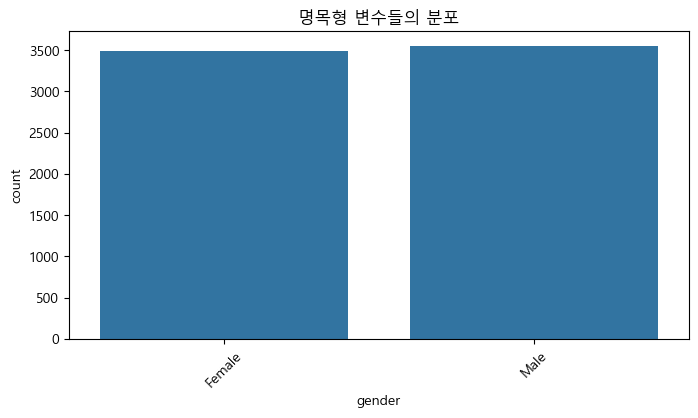

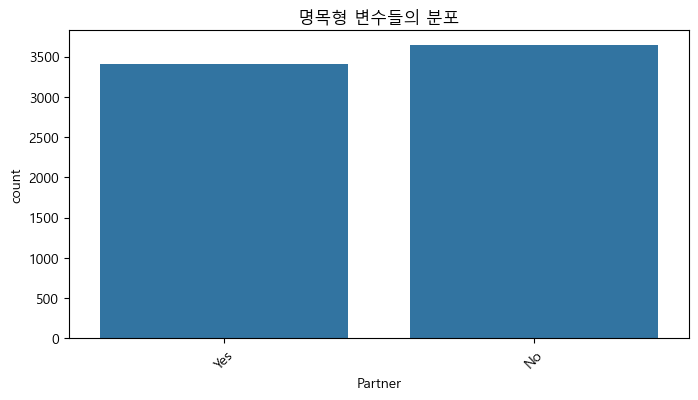

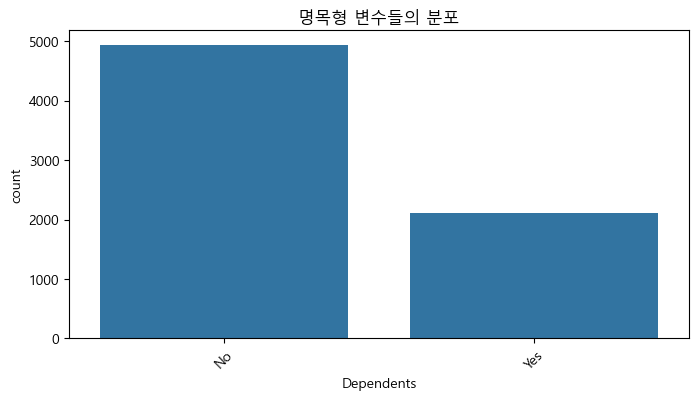

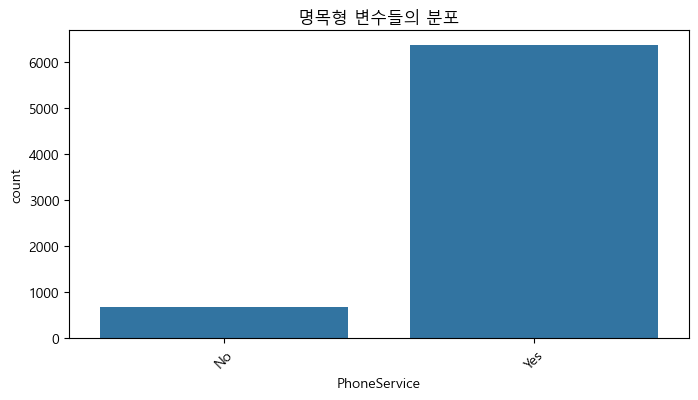

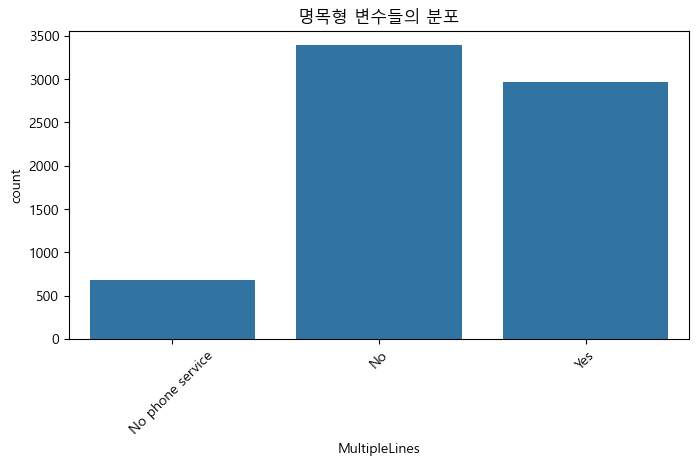

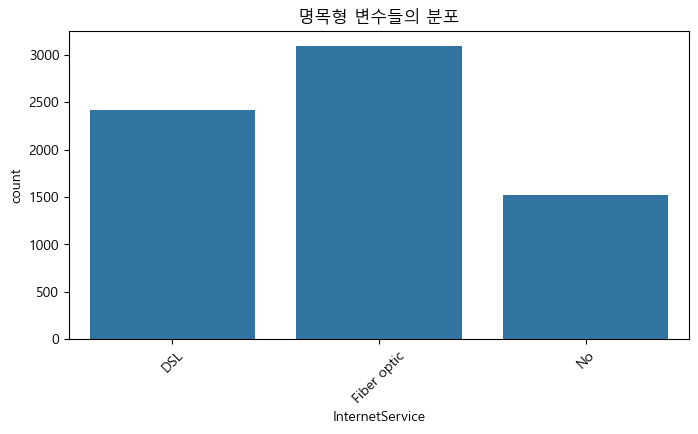

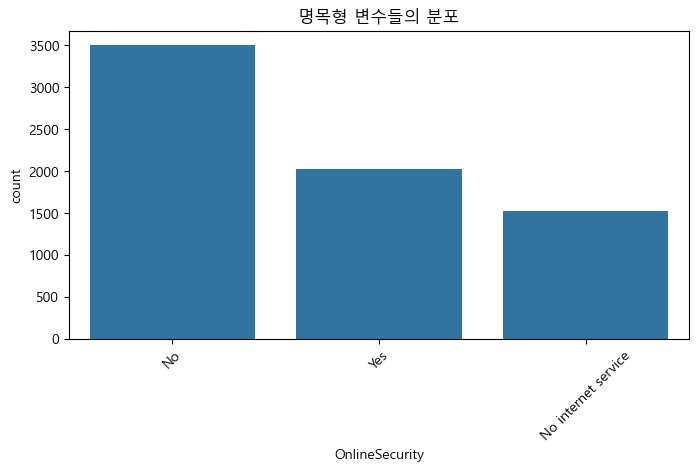

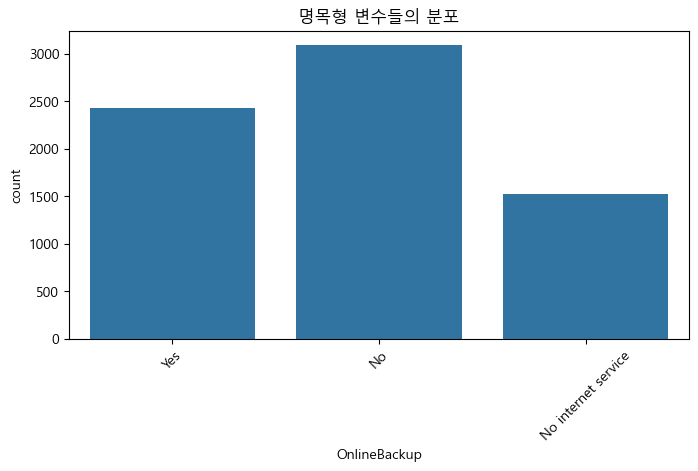

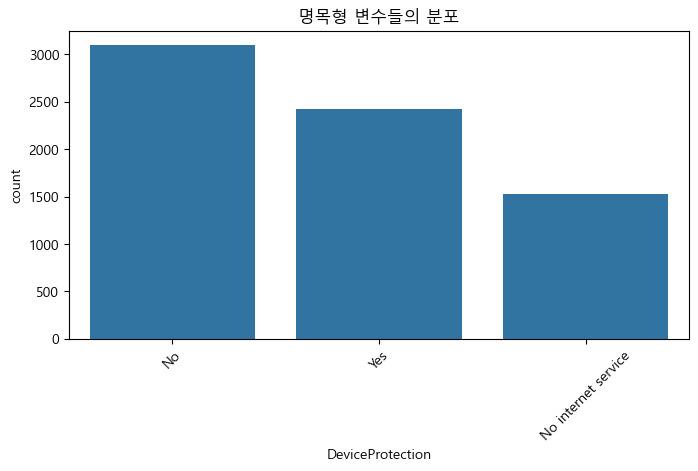

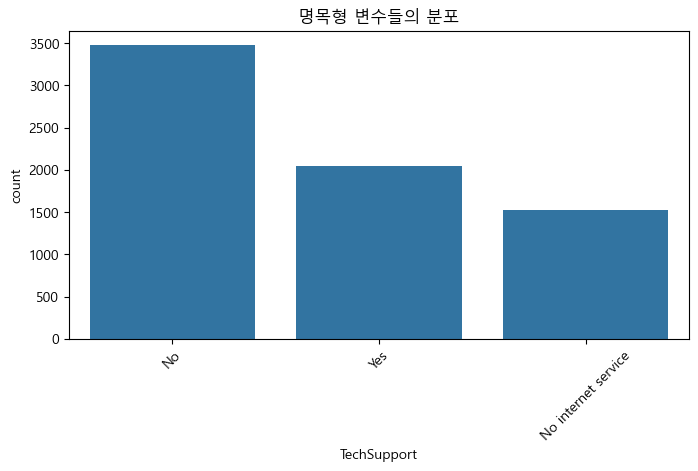

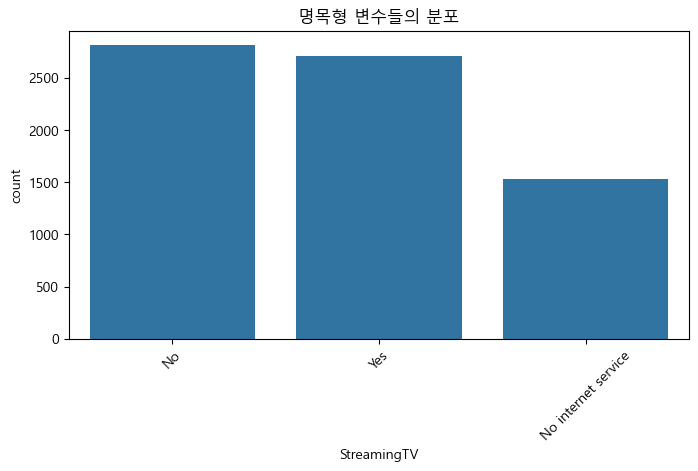

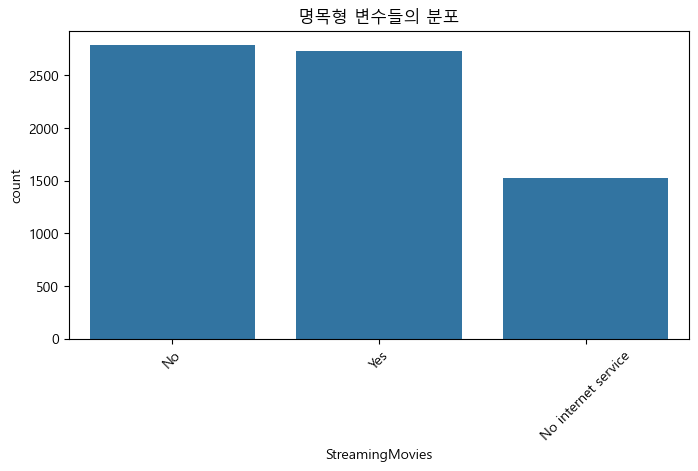

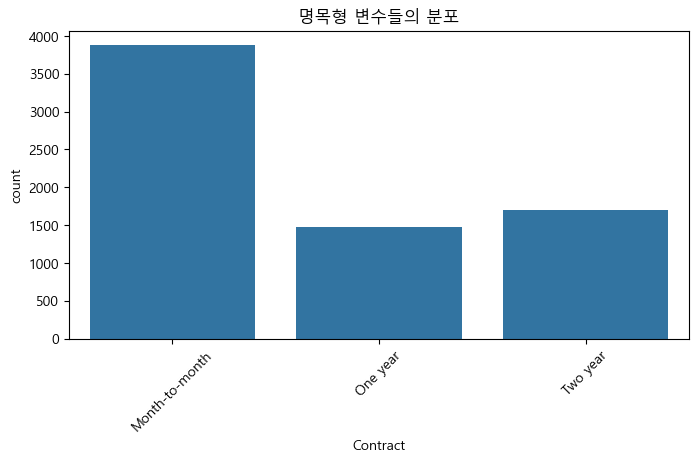

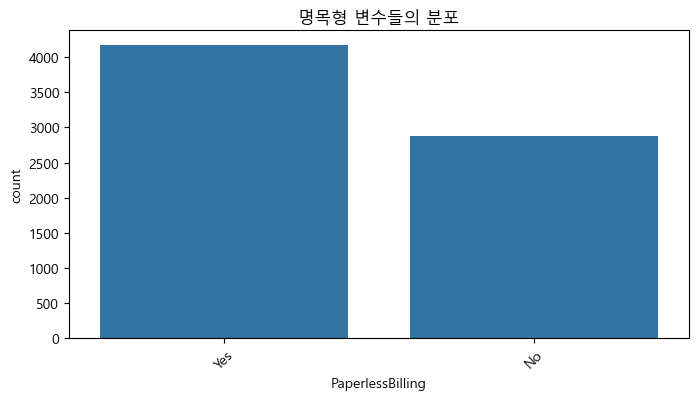

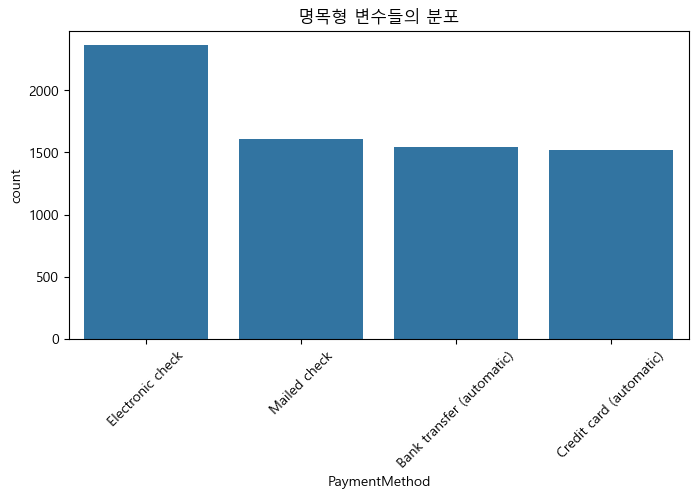

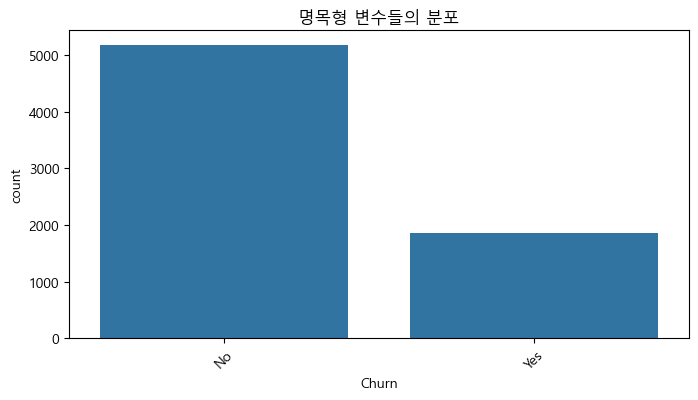

In [12]:
for col in df.select_dtypes(include='object').columns:
    plt.figure(figsize=(8, 4))
    seaborn.countplot(data=df, x=col)
    plt.title(f"명목형 변수들의 분포")
    plt.xticks(rotation=45)
    plt.show()